In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (11,6)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
# rc('text', usetex=True)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})

/home/snikolenko/soft/lectures/lectures/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Hot hand fallacy?

In [ ]:
streak, N, num_experiments = 3, 20, 100000
results, results_streak = [], []
for _ in range(num_experiments):
    x = np.random.randint(2, size=N)
    after_streak = np.array([ i+streak for i in range(N) if np.all(x[i:i+streak] == 1) and (i+streak < N) ])
    if len(after_streak) > 0:
        results_streak.append(np.sum(x[after_streak]) / len(after_streak))
    results.append(np.sum(x) / float(N))

In [ ]:
np.mean(results)

In [ ]:
np.mean(results_streak)

In [ ]:
np.mean(after_streak_avg)

In [ ]:
np.mean(results_streak)

In [ ]:
streak, N, num_experiments = 3, 20, 20000
res = {}
for streak in range(1, 6):
    print("Streak %d..." % streak)
    res[streak] = {}
    for N in [ i for i in range(streak+1, 20)] + [i for i in range(20, 101, 5)]:
        x = np.random.randint(2, size=(num_experiments, N))
        after_streak = [ [i+streak for i in range(N) if np.all(x[j,i:i+streak] == 1) and (i+streak < N)] for j in range(num_experiments) ]
        after_streak_avg = [ np.mean(x[j,a]) for (j,a) in enumerate(after_streak) if len(a) > 0 ]
        res[streak][N] = np.mean(after_streak_avg)

In [ ]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
for streak in range(1, 6):
    xs = sorted(res[streak].keys())
    ax.plot(xs, [res[streak][x] for x in xs], linewidth=2, label="Streak %d" % streak)
ax.set_xlim((0, 100))
ax.set_ylim((.3, 0.5))
ax.legend(loc="lower right", ncol=2, fontsize=legend_fontsize)
plt.show()

# Линейная и полиномиальная регрессия

In [29]:
## Оверфиттинг
## Исходная функция
orig = lambda x : np.sin(2*x)

## X-координаты точек данных
xd = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 1.5, 2.5, 3, 4]) / 2
num_points = len(xd)

## Данные
data = orig(xd) + np.random.normal(0, .35, num_points)

## Для 
xs = np.arange(xd[0]-1.5, xd[-1]+1.5, 0.01)


[ 1.19706052  0.04480657 -0.49255434]
[   4.07592089   11.08596611  -36.0091345   -52.3315787   137.21632478
   27.37686955 -143.1559667    28.69183457   39.52340181  -13.99251729]


(-2.0, 2.5)

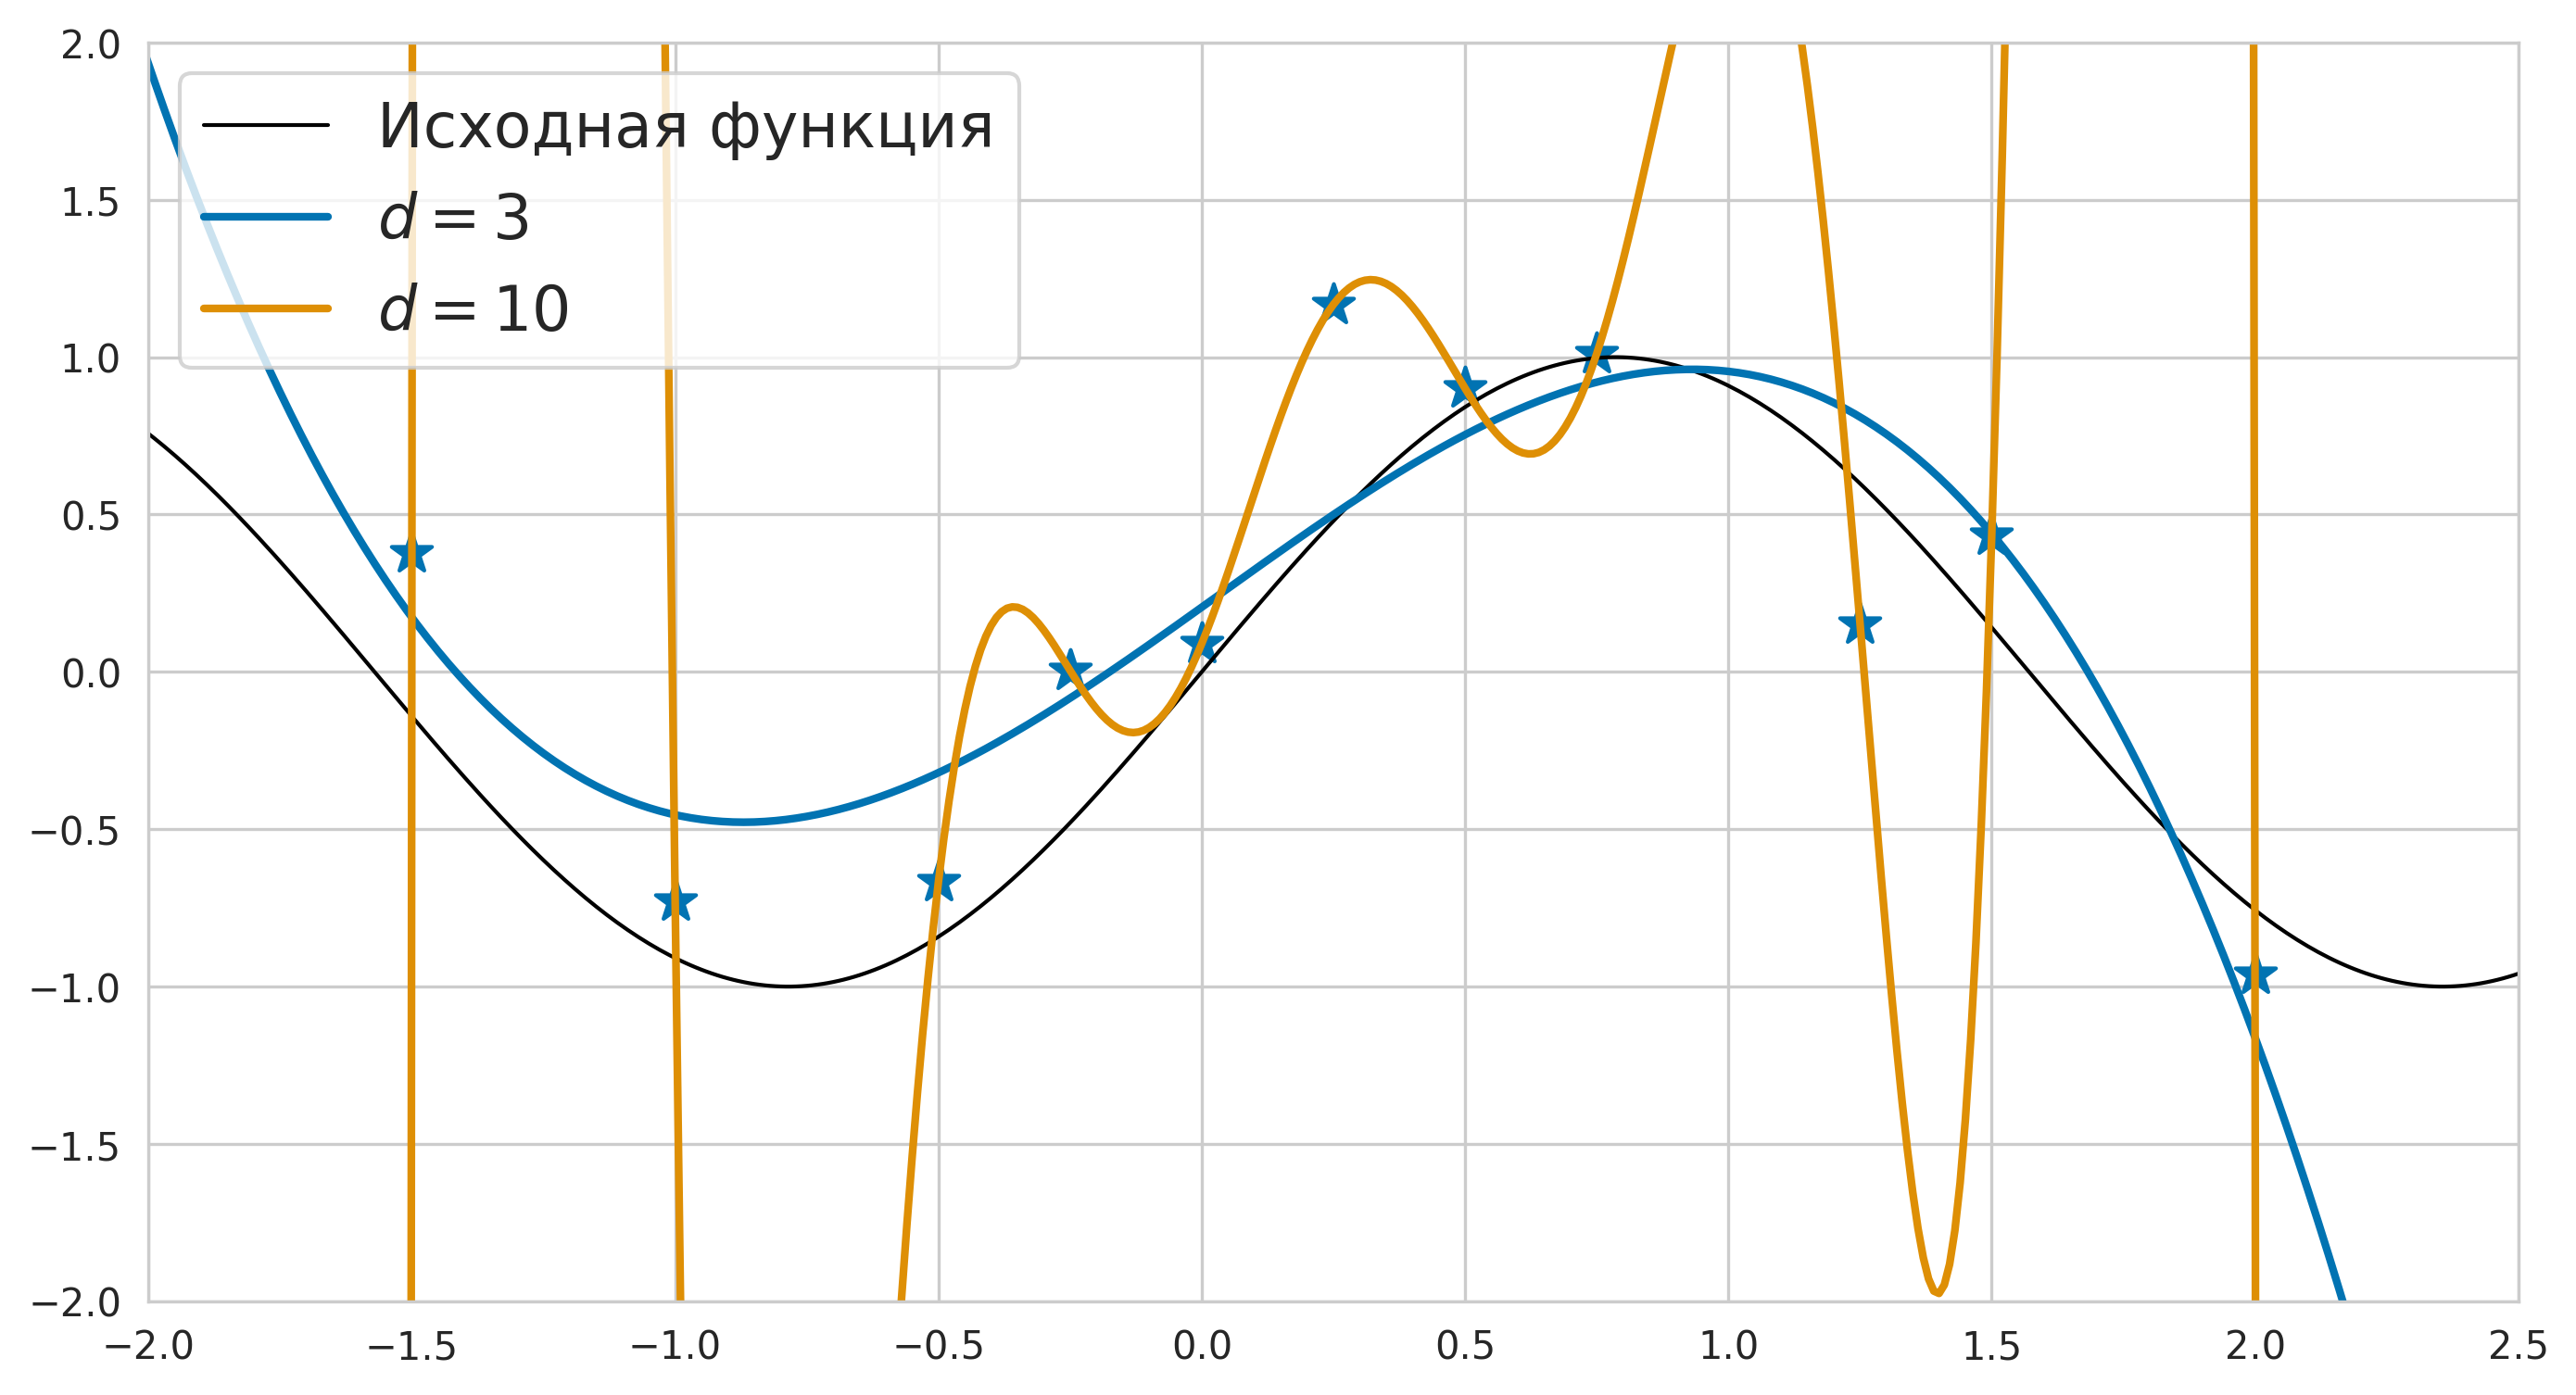

In [38]:
## Выделение полиномиальных признаков
xs_d = np.vstack([xs ** i for i in range(1, num_points+1)]).transpose()
xd_d = np.vstack([xd ** i for i in range(1, num_points+1)]).transpose()

## Какие степени многочлена будем обучать и рисовать
set_of_powers = [3, 10 ]

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-2, 2))
ax.scatter(xd, data, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for d in set_of_powers:
    if d == 0:
        print(np.mean(data))
        ax.hlines(np.mean(data), xmin=xs[0], xmax=xs[-1], label="$d=0$", linestyle="dashed")
    else:
        cur_model = linear_model.LinearRegression(fit_intercept=True).fit( xd_d[:, :d], data )
        print(cur_model.coef_)
        ax.plot(xs, cur_model.predict( xs_d[:, :d] ), linewidth=2, label="$d=%d$" % d)

ax.legend(loc="upper left", fontsize=legend_fontsize)
ax.set_xlim((-2, 2.5))
# plt.show()

## Локальные признаки в линейной регрессии

Коэффициенты с 10 признаками: -25.1108 -22.7339 -24.9973 -22.6502 -22.5457 -21.8231 -21.9227 -22.4306 -22.3958 -26.4959


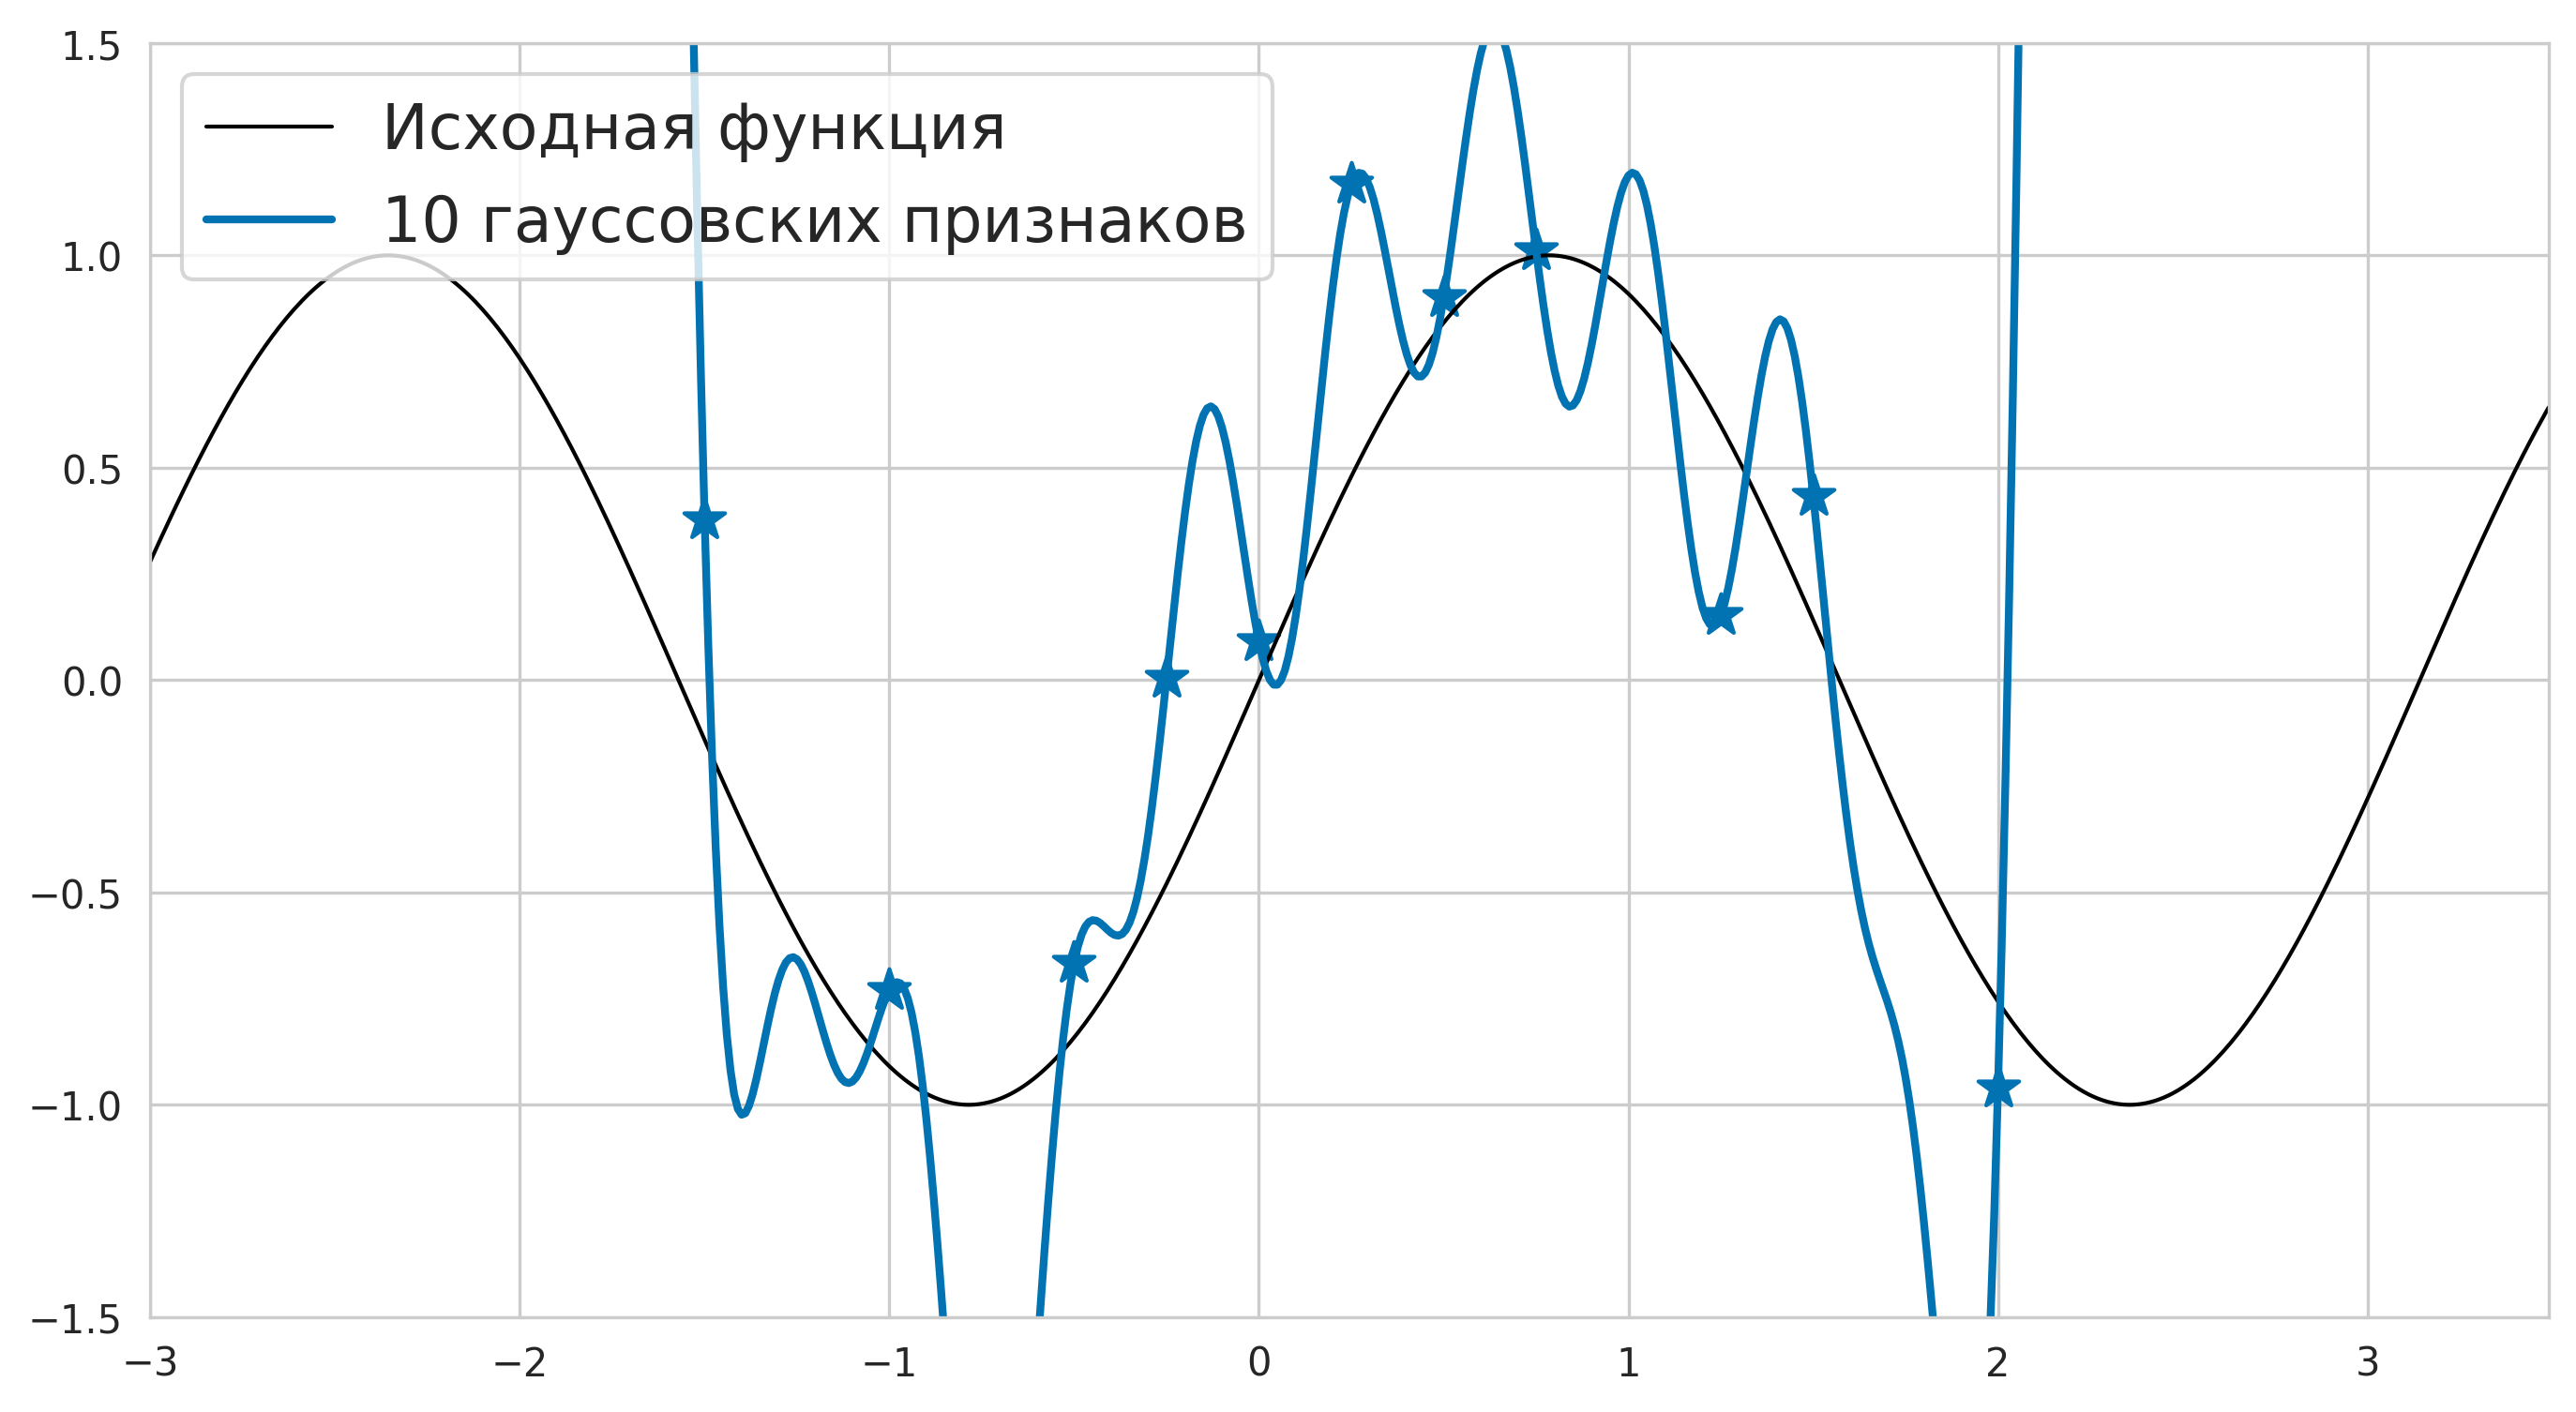

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

nums_gauss = [10 ]
gauss_xd, gauss_yd = xd, data

class GaussianFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, N, width_factor=.5):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_, self.width_, axis=1)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for num_gauss in nums_gauss:
    gauss_model = make_pipeline(GaussianFeatures(num_gauss),
                                linear_model.LinearRegression())
    gauss_model.fit(xd[:, np.newaxis], data)
    yfit = gauss_model.predict(xs[:, np.newaxis])
    print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
    ax.plot(xs, yfit, linewidth=2, label="%d гауссовских признак%s" % (num_gauss, "а" if num_gauss < 5 else "ов") )

ax.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

In [33]:
num_gauss = 10
gauss_model = make_pipeline(GaussianFeatures(num_gauss), linear_model.LinearRegression())
gauss_model.fit(gauss_xd[:, np.newaxis], gauss_yd)
yfit = gauss_model.predict(xs[:, np.newaxis])
mfeat = gauss_model.get_params()['gaussianfeatures']
mregr = gauss_model.get_params()['linearregression']
print("Коэффициенты с %d признаками: %s" % (num_gauss, " ".join(["%.4f" % x for x in gauss_model.get_params()['linearregression'].coef_])))
print("Свободный член: %.4f" % mregr.intercept_)

Коэффициенты с 10 признаками: -25.1108 -22.7339 -24.9973 -22.6502 -22.5457 -21.8231 -21.9227 -22.4306 -22.3958 -26.4959
Свободный член: 28.5740


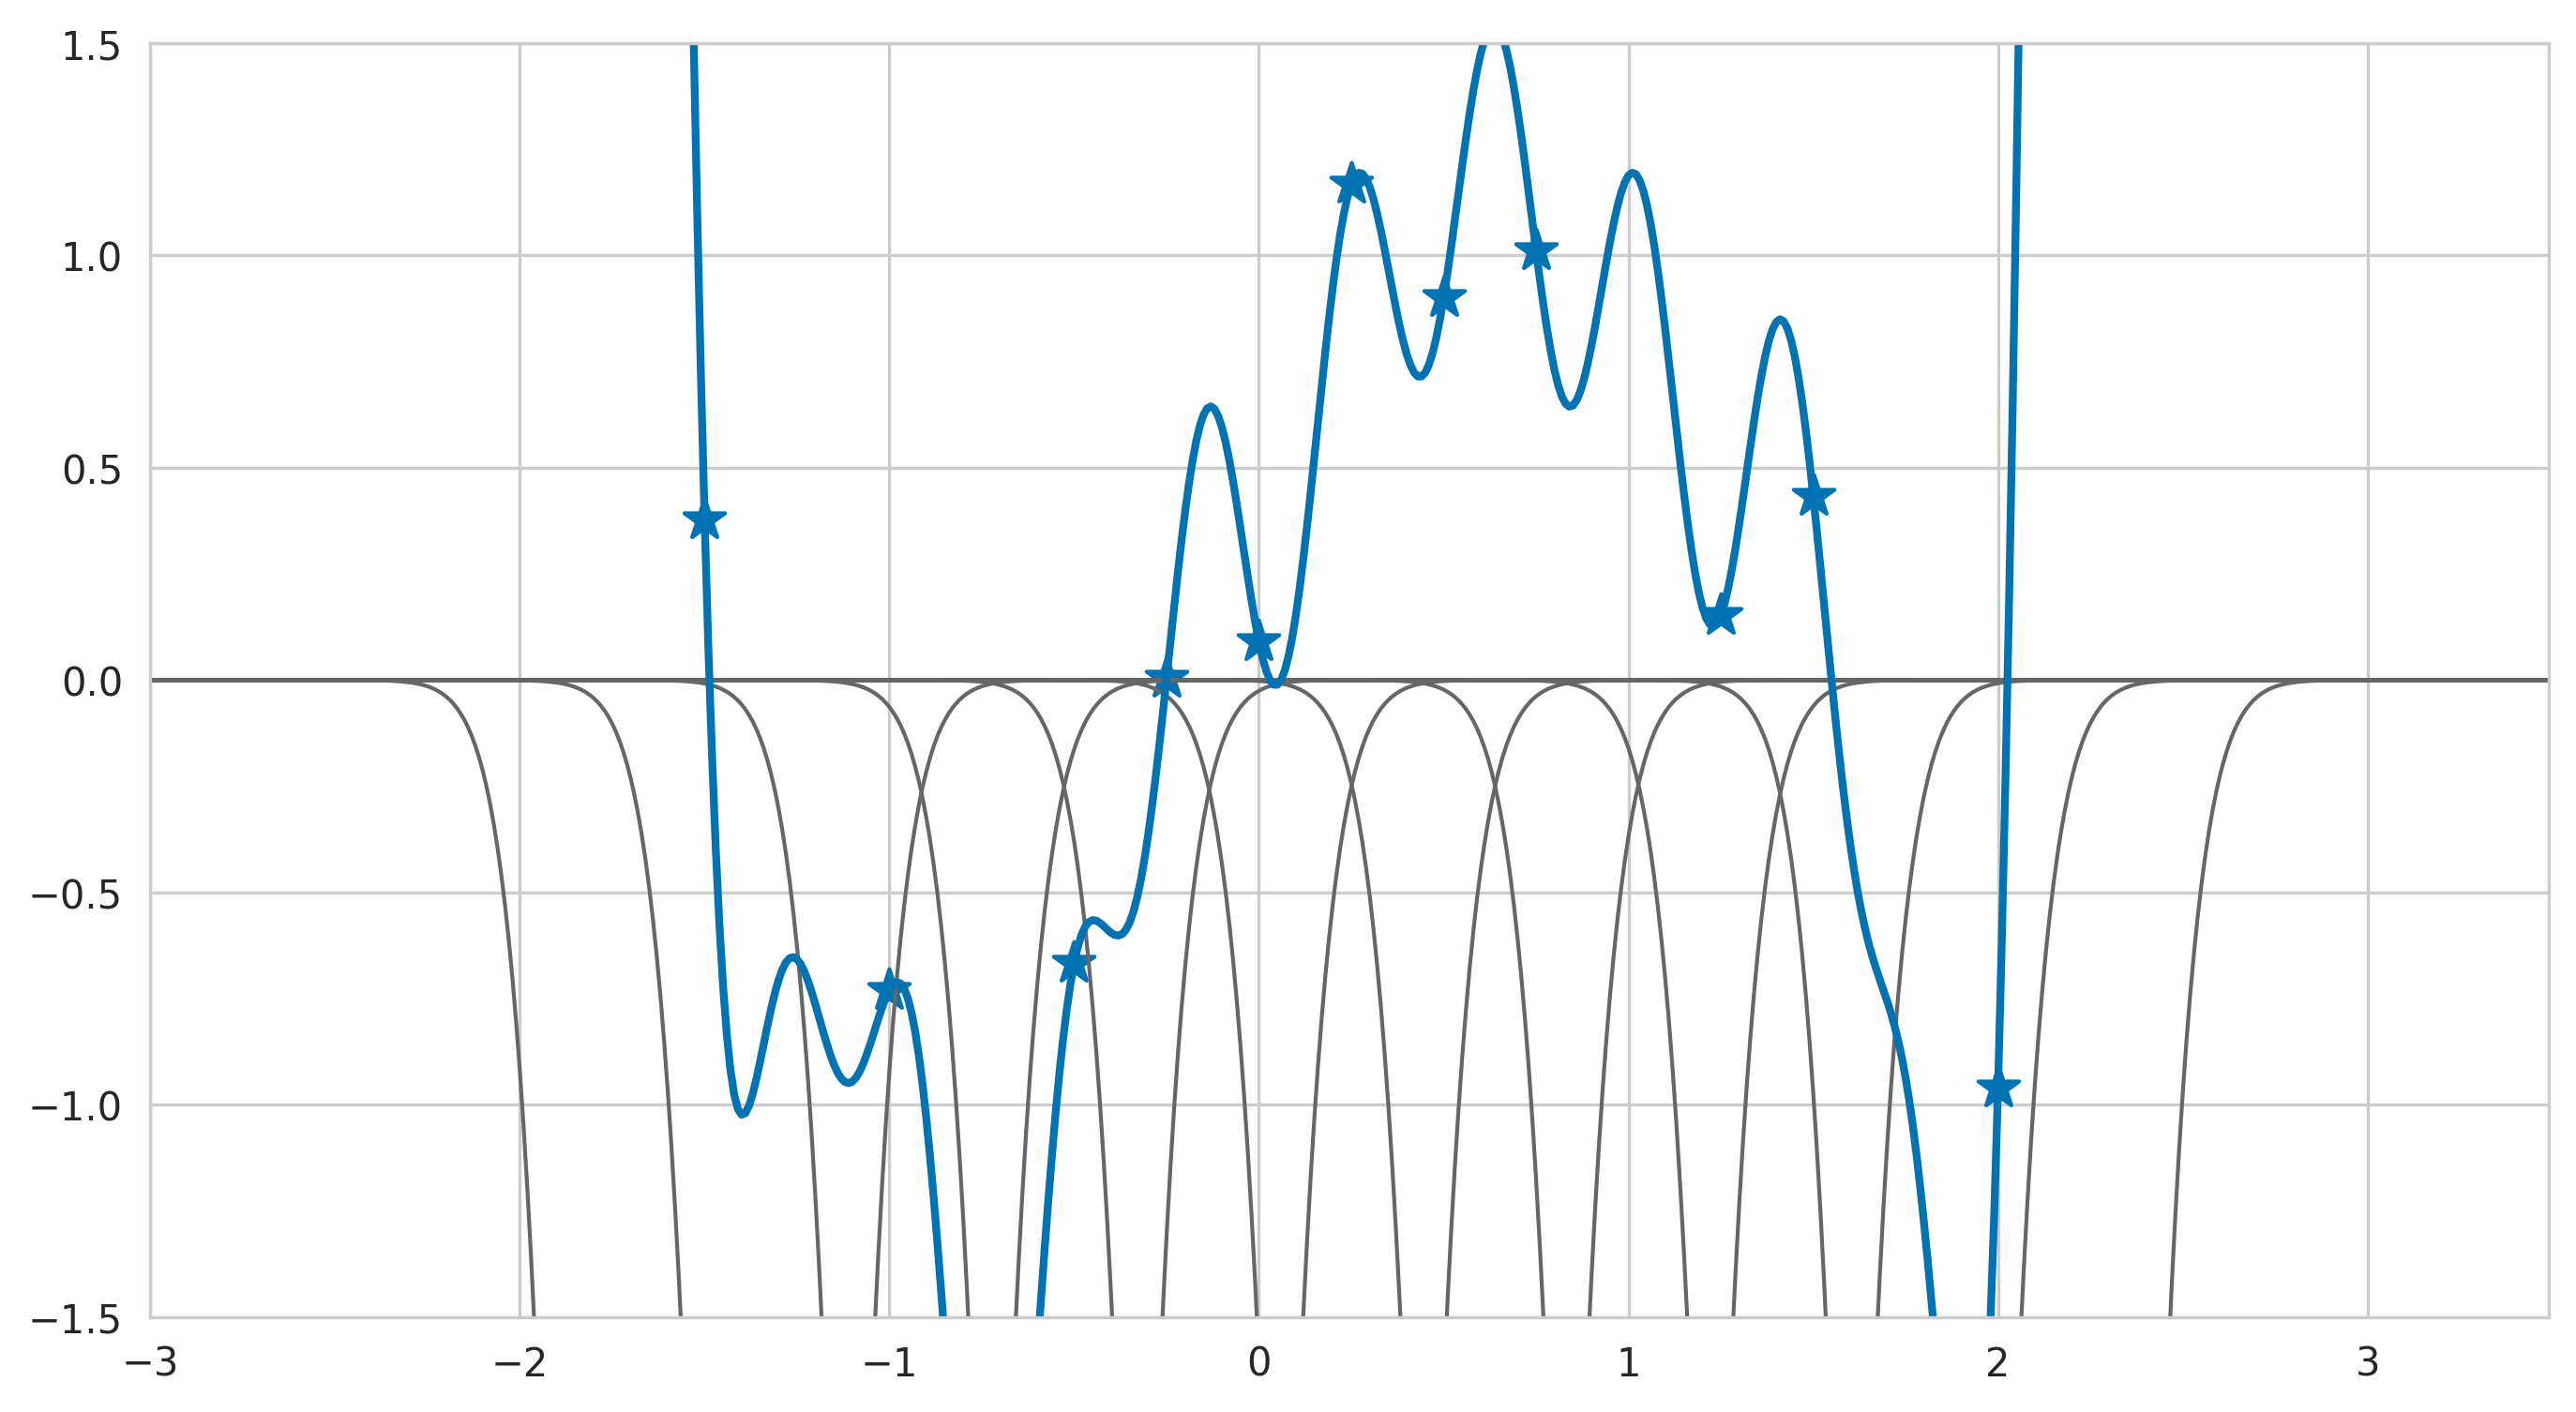

In [35]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))
ax.set_ylim((-1.5, 1.5))
ax.scatter(gauss_xd, gauss_yd, marker='*', s=120)
# ax.plot(xs, orig(xs), linewidth=1, label="Исходная функция", color="black")

for i in range(mfeat.N):
    cur_yfit = [mregr.coef_[i] * mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.4", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)

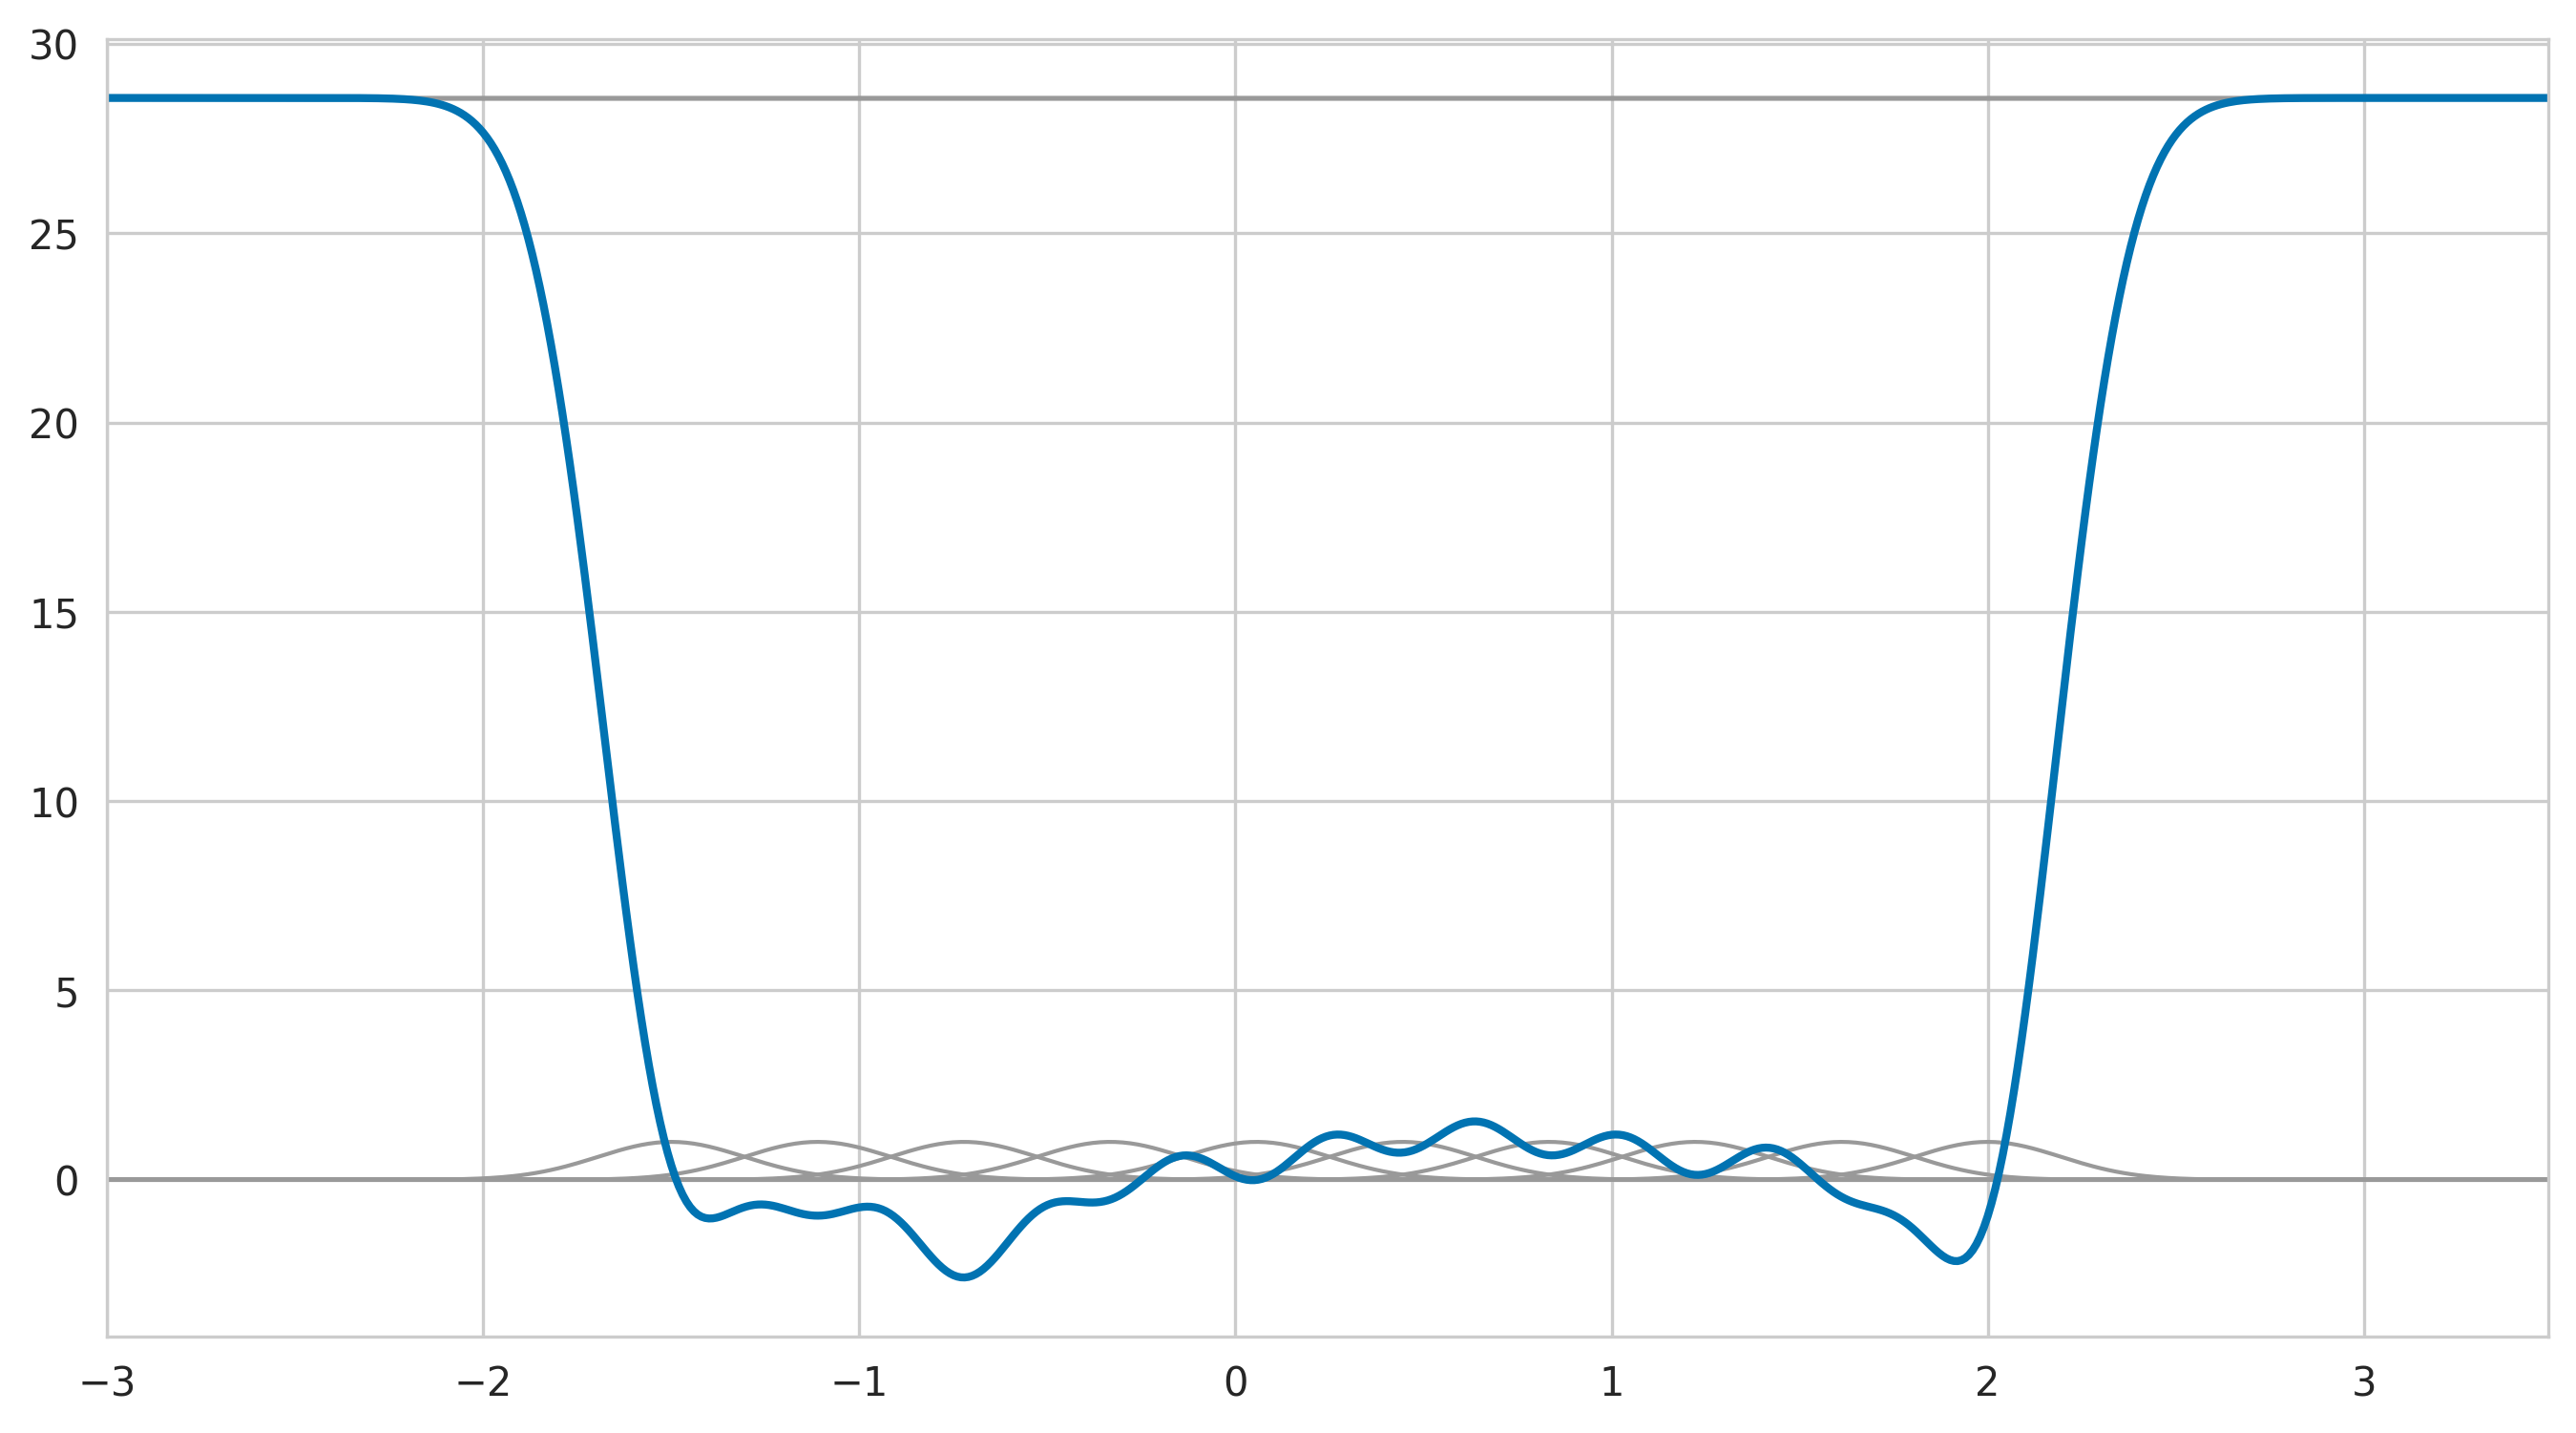

In [36]:
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111)
ax.set_xlim((xs[0], xs[-1]))

for i in range(mfeat.N):
    cur_yfit = [mfeat._gauss_basis(x, mfeat.centers_[i], mfeat.width_) for x in xs]
    ax.plot(xs, cur_yfit, color="0.6", linewidth=1)
    ax.plot(xs, [mregr.intercept_ for _ in range(len(xs))], color="0.6", linewidth=1)

ax.plot(xs, yfit, linewidth=2)